In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import time
import seaborn as sns
import plotly.express as px

<h3>Preprocessing (Loading, removing and showing graphs)</h3>

In [3]:
# Load your CSV dataset (replace 'your_dataset.csv' with your actual dataset)
data = pd.read_csv('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/Obfuscated-MalMem2022-v3.csv')
from sklearn.preprocessing import LabelEncoder
lab=LabelEncoder()
data['class']=lab.fit_transform(data['Class'])
#data['category']=lab.fit_transform(data['Category'])
#data['family']=lab.fit_transform(data['Family'])
data = data.drop(['Class'], axis=1)
data = data.drop(['Category'], axis=1)
data = data.drop(['Family'], axis=1)
#columns with 0 values
data = data.drop(['pslist.nprocs64bit'], axis=1)
data = data.drop(['handles.nport'], axis=1)
data = data.drop(['psxview.not_in_eprocess_pool'], axis=1)
data = data.drop(['psxview.not_in_eprocess_pool_false_avg'], axis=1)
data = data.drop(['svcscan.interactive_process_services'], axis=1)
data = data.drop(['callbacks.nanonymous'], axis=1)
data = data.drop(['modules.nmodules'], axis=1)
data = data.drop(['callbacks.ngeneric'], axis=1)
data = data.drop(['svcscan.fs_drivers'], axis=1)

In [4]:
data = data.drop_duplicates()

<h3>Normalization</h3>

In [5]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Create a Min-Max scaler instance
scaler = StandardScaler()
# Select the columns you want to scale (exclude the target variable if needed)
columns_to_scale = data.columns  # You can select specific columns here

# Fit the scaler on the selected columns and transform the data
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

<h3>Spliting for Training and Testing</h3>

In [6]:
# Separate features and labels
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values   # Class labels
X.shape

(58027, 46)

In [7]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Encode the target labels
smote = SMOTE(random_state=42)

X_smote, y_smote = smote.fit_resample(X, y_encoded)
X_smote.shape

(58462, 46)

<h3>MLP with 20 Epochs Implementation</h3>

Fold 5/5: 100%|██████████| 20/20 [01:08<00:00,  3.41s/it]


Mean Accuracy: 99.99%
Mean Training Time (seconds): 348.06
Mean Testing Time (seconds): 0.00
Mean Training Loss: 0.0015
Mean Test Loss: 0.0041


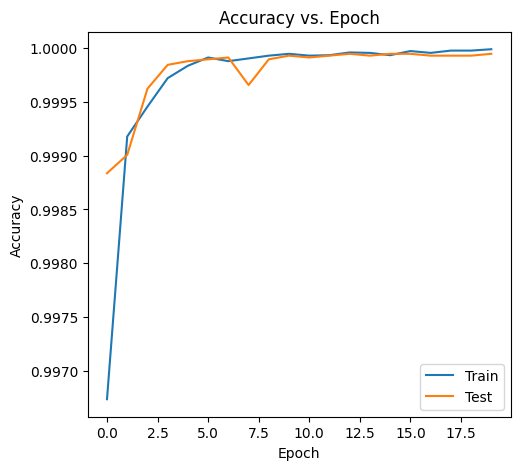

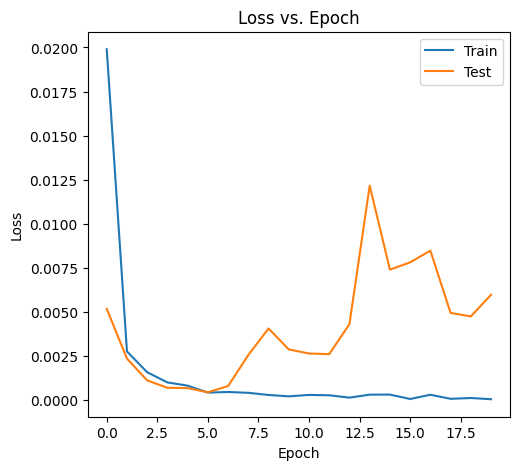

In [8]:
# Convert data to PyTorch tensors
X = torch.tensor(X_smote, dtype=torch.float32)
y = torch.tensor(y_smote, dtype=torch.long)

# Define the number of folds for cross-validation
num_splits = 5  # You can adjust the number of folds as needed

# Initialize lists to store accuracy scores, training and testing loss, and times
fold_accuracies = []
train_losses = []
test_losses = []
train_times = []
test_times = []

all_train_accuracies = []
all_test_accuracies = []
all_train_losses = []
all_test_losses = []

all_true_labels = []
all_predicted_labels = []

# Initialize the cross-validator
kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Define your MLP model
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Specify the model hyperparameters
input_size = X.shape[1]  # Number of input features
hidden_size = 128  # Number of hidden units
num_classes = len(np.unique(y))  # Number of classes

# Loop over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create DataLoader for training and testing
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Create an instance of the MLP model
    model = MLPModel(input_size, hidden_size, num_classes)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 20
    train_losses_fold = []
    test_losses_fold = []
    train_accuracies = []
    test_accuracies = []

    start_time = time.time()

    for epoch in tqdm(range(num_epochs), desc=f'Fold {fold + 1}/{num_splits}'):
        model.train()
        correct_train = 0
        total_train = 0
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Append true labels and predicted labels for this batch
            all_true_labels.extend(labels.tolist())
            all_predicted_labels.extend(predicted.tolist())

        train_accuracy = correct_train / total_train
        train_losses_fold.append(running_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Evaluation on the test set
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        test_accuracy = correct_test / total_test
        test_losses_fold.append(running_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

    # Store the accuracy of this fold
    fold_accuracies.append(test_accuracies[-1])
    train_losses.append(train_losses_fold)
    test_losses.append(test_losses_fold)

    end_time = time.time()
    train_time = end_time - start_time
    train_times.append(train_time)

    # Calculate the testing time for the fold
    start_time = time.time()
    for _ in range(len(test_loader)):
        pass
    end_time = time.time()
    test_time = end_time - start_time
    test_times.append(test_time)

    # Append accuracy and loss for this fold
    all_train_accuracies.append(train_accuracies)
    all_test_accuracies.append(test_accuracies)
    all_train_losses.append(train_losses_fold)
    all_test_losses.append(test_losses_fold)

# Calculate and print the mean accuracy across all folds
mean_accuracy = np.mean(fold_accuracies)
print(f'Mean Accuracy: {mean_accuracy * 100:.2f}%')

# Calculate and print the total test loss across all folds
total_test_loss = sum([sum(loss) for loss in all_test_losses])

# Calculate and print the total average test loss (across all epochs and folds)
total_average_test_loss = total_test_loss / (num_splits * num_epochs)

# Calculate and print the mean training and testing times across all folds
mean_train_time = np.sum(train_times)
mean_test_time = np.sum(test_times)
print(f'Mean Training Time (seconds): {mean_train_time:.2f}')
print(f'Mean Testing Time (seconds): {mean_test_time:.2f}')

# Calculate and print the mean training loss across all epochs and folds
mean_training_loss = np.mean([np.mean(loss) for loss in all_train_losses])
print(f'Mean Training Loss: {mean_training_loss:.4f}')

# Calculate and print the mean test loss across all epochs and folds
mean_test_loss = np.mean([np.mean(loss) for loss in all_test_losses])
print(f'Mean Test Loss: {mean_test_loss:.4f}')

# Plot training and test accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
mean_train_accuracies = np.mean(all_train_accuracies, axis=0)
mean_test_accuracies = np.mean(all_test_accuracies, axis=0)
plt.plot(range(num_epochs), mean_train_accuracies, label="Train")
plt.plot(range(num_epochs), mean_test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/mlp/20_epochs_accuracy.pdf', format='pdf')
plt.show()
plt.close()
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
mean_train_losses = np.mean(all_train_losses, axis=0)
mean_test_losses = np.mean(all_test_losses, axis=0)
plt.plot(range(num_epochs), mean_train_losses, label="Train")
plt.plot(range(num_epochs), mean_test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/mlp/20_epochs_loss.pdf', format='pdf')
plt.show()
plt.close()

<h3>MLP with 30 Epochs Implementation</h3>

Fold 5/5: 100%|██████████| 30/30 [01:50<00:00,  3.69s/it]


Mean Accuracy: 99.99%
Mean Training Time (seconds): 497.68
Mean Testing Time (seconds): 0.00
Mean Training Loss: 0.0010
Mean Test Loss: 0.0008


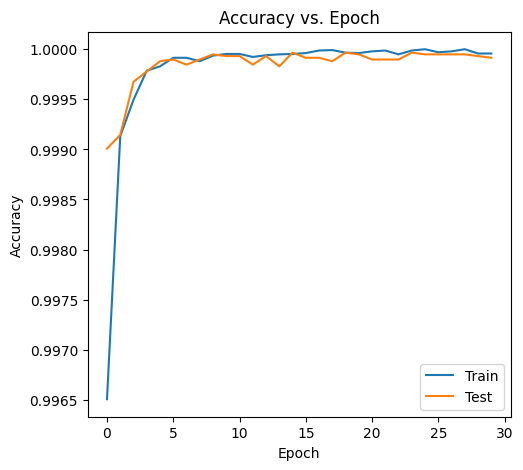

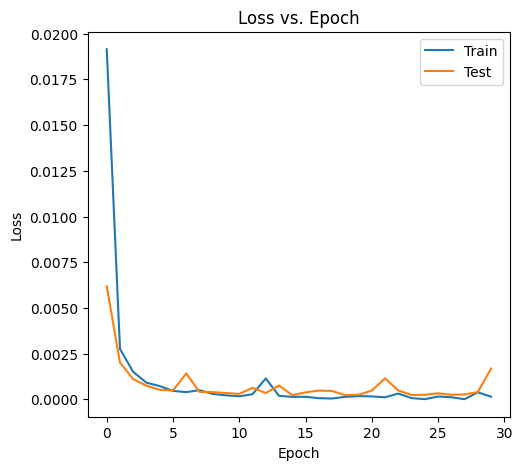

In [9]:
# Convert data to PyTorch tensors
X = torch.tensor(X_smote, dtype=torch.float32)
y = torch.tensor(y_smote, dtype=torch.long)

# Define the number of folds for cross-validation
num_splits = 5  # You can adjust the number of folds as needed

# Initialize lists to store accuracy scores, training and testing loss, and times
fold_accuracies = []
train_losses = []
test_losses = []
train_times = []
test_times = []

all_train_accuracies = []
all_test_accuracies = []
all_train_losses = []
all_test_losses = []

all_true_labels = []
all_predicted_labels = []

# Initialize the cross-validator
kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Define your MLP model
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Specify the model hyperparameters
input_size = X.shape[1]  # Number of input features
hidden_size = 128  # Number of hidden units
num_classes = len(np.unique(y))  # Number of classes

# Loop over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create DataLoader for training and testing
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Create an instance of the MLP model
    model = MLPModel(input_size, hidden_size, num_classes)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 30
    train_losses_fold = []
    test_losses_fold = []
    train_accuracies = []
    test_accuracies = []

    start_time = time.time()

    for epoch in tqdm(range(num_epochs), desc=f'Fold {fold + 1}/{num_splits}'):
        model.train()
        correct_train = 0
        total_train = 0
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Append true labels and predicted labels for this batch
            all_true_labels.extend(labels.tolist())
            all_predicted_labels.extend(predicted.tolist())

        train_accuracy = correct_train / total_train
        train_losses_fold.append(running_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Evaluation on the test set
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        test_accuracy = correct_test / total_test
        test_losses_fold.append(running_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

    # Store the accuracy of this fold
    fold_accuracies.append(test_accuracies[-1])
    train_losses.append(train_losses_fold)
    test_losses.append(test_losses_fold)

    end_time = time.time()
    train_time = end_time - start_time
    train_times.append(train_time)

    # Calculate the testing time for the fold
    start_time = time.time()
    for _ in range(len(test_loader)):
        pass
    end_time = time.time()
    test_time = end_time - start_time
    test_times.append(test_time)

    # Append accuracy and loss for this fold
    all_train_accuracies.append(train_accuracies)
    all_test_accuracies.append(test_accuracies)
    all_train_losses.append(train_losses_fold)
    all_test_losses.append(test_losses_fold)

# Calculate and print the mean accuracy across all folds
mean_accuracy = np.mean(fold_accuracies)
print(f'Mean Accuracy: {mean_accuracy * 100:.2f}%')

# Calculate and print the total test loss across all folds
total_test_loss = sum([sum(loss) for loss in all_test_losses])

# Calculate and print the total average test loss (across all epochs and folds)
total_average_test_loss = total_test_loss / (num_splits * num_epochs)

# Calculate and print the mean training and testing times across all folds
mean_train_time = np.sum(train_times)
mean_test_time = np.sum(test_times)
print(f'Mean Training Time (seconds): {mean_train_time:.2f}')
print(f'Mean Testing Time (seconds): {mean_test_time:.2f}')

# Calculate and print the mean training loss across all epochs and folds
mean_training_loss = np.mean([np.mean(loss) for loss in all_train_losses])
print(f'Mean Training Loss: {mean_training_loss:.4f}')

# Calculate and print the mean test loss across all epochs and folds
mean_test_loss = np.mean([np.mean(loss) for loss in all_test_losses])
print(f'Mean Test Loss: {mean_test_loss:.4f}')

# Plot training and test accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
mean_train_accuracies = np.mean(all_train_accuracies, axis=0)
mean_test_accuracies = np.mean(all_test_accuracies, axis=0)
plt.plot(range(num_epochs), mean_train_accuracies, label="Train")
plt.plot(range(num_epochs), mean_test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/mlp/30_epochs_accuracy.pdf', format='pdf')
plt.show()
plt.close()
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
mean_train_losses = np.mean(all_train_losses, axis=0)
mean_test_losses = np.mean(all_test_losses, axis=0)
plt.plot(range(num_epochs), mean_train_losses, label="Train")
plt.plot(range(num_epochs), mean_test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/mlp/30_epochs_loss.pdf', format='pdf')
plt.show()
plt.close()

<h3>MLP with 50 Epochs Implementation</h3>

Fold 5/5: 100%|██████████| 50/50 [02:49<00:00,  3.39s/it]


Mean Accuracy: 100.00%
Mean Training Time (seconds): 782.52
Mean Testing Time (seconds): 0.00
Mean Training Loss: 0.0007
Mean Test Loss: 0.0028


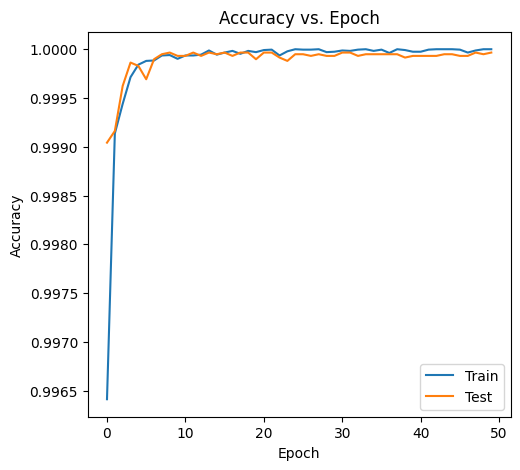

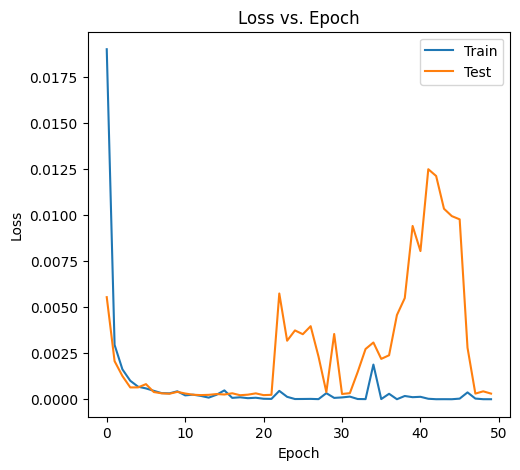

In [10]:
# Convert data to PyTorch tensors
X = torch.tensor(X_smote, dtype=torch.float32)
y = torch.tensor(y_smote, dtype=torch.long)

# Define the number of folds for cross-validation
num_splits = 5  # You can adjust the number of folds as needed

# Initialize lists to store accuracy scores, training and testing loss, and times
fold_accuracies = []
train_losses = []
test_losses = []
train_times = []
test_times = []

all_train_accuracies = []
all_test_accuracies = []
all_train_losses = []
all_test_losses = []

all_true_labels = []
all_predicted_labels = []

# Initialize the cross-validator
kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Define your MLP model
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Specify the model hyperparameters
input_size = X.shape[1]  # Number of input features
hidden_size = 128  # Number of hidden units
num_classes = len(np.unique(y))  # Number of classes

# Loop over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create DataLoader for training and testing
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Create an instance of the MLP model
    model = MLPModel(input_size, hidden_size, num_classes)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 50
    train_losses_fold = []
    test_losses_fold = []
    train_accuracies = []
    test_accuracies = []

    start_time = time.time()

    for epoch in tqdm(range(num_epochs), desc=f'Fold {fold + 1}/{num_splits}'):
        model.train()
        correct_train = 0
        total_train = 0
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Append true labels and predicted labels for this batch
            all_true_labels.extend(labels.tolist())
            all_predicted_labels.extend(predicted.tolist())

        train_accuracy = correct_train / total_train
        train_losses_fold.append(running_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Evaluation on the test set
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        test_accuracy = correct_test / total_test
        test_losses_fold.append(running_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

    # Store the accuracy of this fold
    fold_accuracies.append(test_accuracies[-1])
    train_losses.append(train_losses_fold)
    test_losses.append(test_losses_fold)

    end_time = time.time()
    train_time = end_time - start_time
    train_times.append(train_time)

    # Calculate the testing time for the fold
    start_time = time.time()
    for _ in range(len(test_loader)):
        pass
    end_time = time.time()
    test_time = end_time - start_time
    test_times.append(test_time)

    # Append accuracy and loss for this fold
    all_train_accuracies.append(train_accuracies)
    all_test_accuracies.append(test_accuracies)
    all_train_losses.append(train_losses_fold)
    all_test_losses.append(test_losses_fold)

# Calculate and print the mean accuracy across all folds
mean_accuracy = np.mean(fold_accuracies)
print(f'Mean Accuracy: {mean_accuracy * 100:.2f}%')

# Calculate and print the total test loss across all folds
total_test_loss = sum([sum(loss) for loss in all_test_losses])

# Calculate and print the total average test loss (across all epochs and folds)
total_average_test_loss = total_test_loss / (num_splits * num_epochs)

# Calculate and print the mean training and testing times across all folds
mean_train_time = np.sum(train_times)
mean_test_time = np.sum(test_times)
print(f'Mean Training Time (seconds): {mean_train_time:.2f}')
print(f'Mean Testing Time (seconds): {mean_test_time:.2f}')

# Calculate and print the mean training loss across all epochs and folds
mean_training_loss = np.mean([np.mean(loss) for loss in all_train_losses])
print(f'Mean Training Loss: {mean_training_loss:.4f}')

# Calculate and print the mean test loss across all epochs and folds
mean_test_loss = np.mean([np.mean(loss) for loss in all_test_losses])
print(f'Mean Test Loss: {mean_test_loss:.4f}')

# Plot training and test accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
mean_train_accuracies = np.mean(all_train_accuracies, axis=0)
mean_test_accuracies = np.mean(all_test_accuracies, axis=0)
plt.plot(range(num_epochs), mean_train_accuracies, label="Train")
plt.plot(range(num_epochs), mean_test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/mlp/50_epochs_accuracy.pdf', format='pdf')
plt.show()
plt.close()
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
mean_train_losses = np.mean(all_train_losses, axis=0)
mean_test_losses = np.mean(all_test_losses, axis=0)
plt.plot(range(num_epochs), mean_train_losses, label="Train")
plt.plot(range(num_epochs), mean_test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/mlp/50_epochs_loss.pdf', format='pdf')
plt.show()
plt.close()

<h3>MLP with 100 Epochs Implementation</h3>

Fold 5/5: 100%|██████████| 100/100 [04:56<00:00,  2.97s/it]


Mean Accuracy: 99.99%
Mean Training Time (seconds): 1534.59
Mean Testing Time (seconds): 0.00
Mean Training Loss: 0.0003
Mean Test Loss: 0.0138


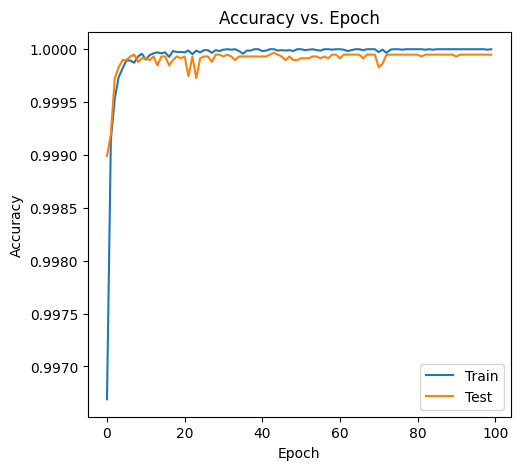

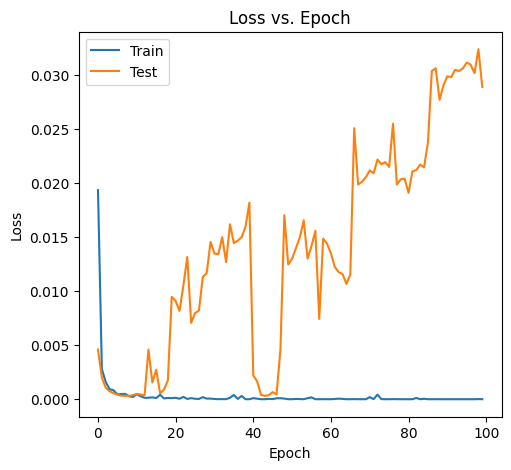

In [11]:
# Convert data to PyTorch tensors
X = torch.tensor(X_smote, dtype=torch.float32)
y = torch.tensor(y_smote, dtype=torch.long)

# Define the number of folds for cross-validation
num_splits = 5  # You can adjust the number of folds as needed

# Initialize lists to store accuracy scores, training and testing loss, and times
fold_accuracies = []
train_losses = []
test_losses = []
train_times = []
test_times = []

all_train_accuracies = []
all_test_accuracies = []
all_train_losses = []
all_test_losses = []

all_true_labels = []
all_predicted_labels = []

# Initialize the cross-validator
kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Define your MLP model
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Specify the model hyperparameters
input_size = X.shape[1]  # Number of input features
hidden_size = 128  # Number of hidden units
num_classes = len(np.unique(y))  # Number of classes

# Loop over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create DataLoader for training and testing
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Create an instance of the MLP model
    model = MLPModel(input_size, hidden_size, num_classes)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 100
    train_losses_fold = []
    test_losses_fold = []
    train_accuracies = []
    test_accuracies = []

    start_time = time.time()

    for epoch in tqdm(range(num_epochs), desc=f'Fold {fold + 1}/{num_splits}'):
        model.train()
        correct_train = 0
        total_train = 0
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Append true labels and predicted labels for this batch
            all_true_labels.extend(labels.tolist())
            all_predicted_labels.extend(predicted.tolist())

        train_accuracy = correct_train / total_train
        train_losses_fold.append(running_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Evaluation on the test set
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        test_accuracy = correct_test / total_test
        test_losses_fold.append(running_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

    # Store the accuracy of this fold
    fold_accuracies.append(test_accuracies[-1])
    train_losses.append(train_losses_fold)
    test_losses.append(test_losses_fold)

    end_time = time.time()
    train_time = end_time - start_time
    train_times.append(train_time)

    # Calculate the testing time for the fold
    start_time = time.time()
    for _ in range(len(test_loader)):
        pass
    end_time = time.time()
    test_time = end_time - start_time
    test_times.append(test_time)

    # Append accuracy and loss for this fold
    all_train_accuracies.append(train_accuracies)
    all_test_accuracies.append(test_accuracies)
    all_train_losses.append(train_losses_fold)
    all_test_losses.append(test_losses_fold)

# Calculate and print the mean accuracy across all folds
mean_accuracy = np.mean(fold_accuracies)
print(f'Mean Accuracy: {mean_accuracy * 100:.2f}%')

# Calculate and print the total test loss across all folds
total_test_loss = sum([sum(loss) for loss in all_test_losses])

# Calculate and print the total average test loss (across all epochs and folds)
total_average_test_loss = total_test_loss / (num_splits * num_epochs)

# Calculate and print the mean training and testing times across all folds
mean_train_time = np.sum(train_times)
mean_test_time = np.sum(test_times)
print(f'Mean Training Time (seconds): {mean_train_time:.2f}')
print(f'Mean Testing Time (seconds): {mean_test_time:.2f}')

# Calculate and print the mean training loss across all epochs and folds
mean_training_loss = np.mean([np.mean(loss) for loss in all_train_losses])
print(f'Mean Training Loss: {mean_training_loss:.4f}')

# Calculate and print the mean test loss across all epochs and folds
mean_test_loss = np.mean([np.mean(loss) for loss in all_test_losses])
print(f'Mean Test Loss: {mean_test_loss:.4f}')

# Plot training and test accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
mean_train_accuracies = np.mean(all_train_accuracies, axis=0)
mean_test_accuracies = np.mean(all_test_accuracies, axis=0)
plt.plot(range(num_epochs), mean_train_accuracies, label="Train")
plt.plot(range(num_epochs), mean_test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/mlp/100_epochs_accuracy.pdf', format='pdf')
plt.show()
plt.close()
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
mean_train_losses = np.mean(all_train_losses, axis=0)
mean_test_losses = np.mean(all_test_losses, axis=0)
plt.plot(range(num_epochs), mean_train_losses, label="Train")
plt.plot(range(num_epochs), mean_test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/mlp/100_epochs_loss.pdf', format='pdf')
plt.show()
plt.close()

<h3>MLP with 150 Epochs Implementation</h3>

Fold 5/5: 100%|██████████| 150/150 [08:02<00:00,  3.21s/it]


Mean Accuracy: 99.99%
Mean Training Time (seconds): 2421.34
Mean Testing Time (seconds): 0.00
Mean Training Loss: 0.0002
Mean Test Loss: 0.0067


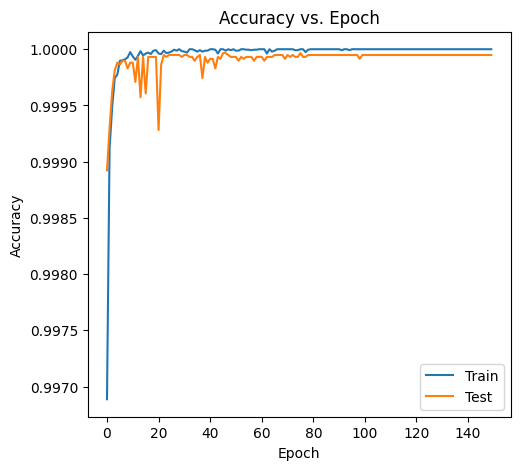

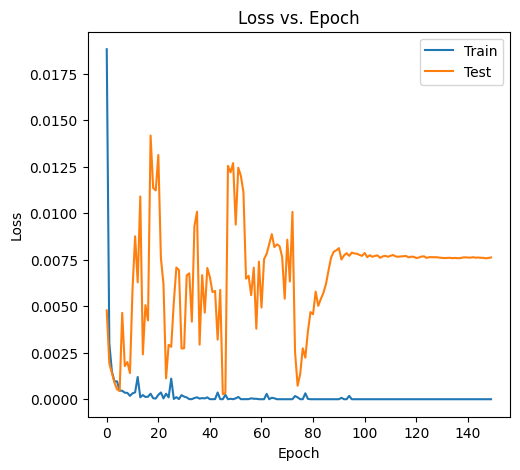

In [12]:
# Convert data to PyTorch tensors
X = torch.tensor(X_smote, dtype=torch.float32)
y = torch.tensor(y_smote, dtype=torch.long)

# Define the number of folds for cross-validation
num_splits = 5  # You can adjust the number of folds as needed

# Initialize lists to store accuracy scores, training and testing loss, and times
fold_accuracies = []
train_losses = []
test_losses = []
train_times = []
test_times = []

all_train_accuracies = []
all_test_accuracies = []
all_train_losses = []
all_test_losses = []

all_true_labels = []
all_predicted_labels = []

# Initialize the cross-validator
kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Define your MLP model
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Specify the model hyperparameters
input_size = X.shape[1]  # Number of input features
hidden_size = 128  # Number of hidden units
num_classes = len(np.unique(y))  # Number of classes

# Loop over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create DataLoader for training and testing
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Create an instance of the MLP model
    model = MLPModel(input_size, hidden_size, num_classes)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 150
    train_losses_fold = []
    test_losses_fold = []
    train_accuracies = []
    test_accuracies = []

    start_time = time.time()

    for epoch in tqdm(range(num_epochs), desc=f'Fold {fold + 1}/{num_splits}'):
        model.train()
        correct_train = 0
        total_train = 0
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Append true labels and predicted labels for this batch
            all_true_labels.extend(labels.tolist())
            all_predicted_labels.extend(predicted.tolist())

        train_accuracy = correct_train / total_train
        train_losses_fold.append(running_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Evaluation on the test set
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        test_accuracy = correct_test / total_test
        test_losses_fold.append(running_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

    # Store the accuracy of this fold
    fold_accuracies.append(test_accuracies[-1])
    train_losses.append(train_losses_fold)
    test_losses.append(test_losses_fold)

    end_time = time.time()
    train_time = end_time - start_time
    train_times.append(train_time)

    # Calculate the testing time for the fold
    start_time = time.time()
    for _ in range(len(test_loader)):
        pass
    end_time = time.time()
    test_time = end_time - start_time
    test_times.append(test_time)

    # Append accuracy and loss for this fold
    all_train_accuracies.append(train_accuracies)
    all_test_accuracies.append(test_accuracies)
    all_train_losses.append(train_losses_fold)
    all_test_losses.append(test_losses_fold)

# Calculate and print the mean accuracy across all folds
mean_accuracy = np.mean(fold_accuracies)
print(f'Mean Accuracy: {mean_accuracy * 100:.2f}%')

# Calculate and print the total test loss across all folds
total_test_loss = sum([sum(loss) for loss in all_test_losses])

# Calculate and print the total average test loss (across all epochs and folds)
total_average_test_loss = total_test_loss / (num_splits * num_epochs)

# Calculate and print the mean training and testing times across all folds
mean_train_time = np.sum(train_times)
mean_test_time = np.sum(test_times)
print(f'Mean Training Time (seconds): {mean_train_time:.2f}')
print(f'Mean Testing Time (seconds): {mean_test_time:.2f}')

# Calculate and print the mean training loss across all epochs and folds
mean_training_loss = np.mean([np.mean(loss) for loss in all_train_losses])
print(f'Mean Training Loss: {mean_training_loss:.4f}')

# Calculate and print the mean test loss across all epochs and folds
mean_test_loss = np.mean([np.mean(loss) for loss in all_test_losses])
print(f'Mean Test Loss: {mean_test_loss:.4f}')

# Plot training and test accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
mean_train_accuracies = np.mean(all_train_accuracies, axis=0)
mean_test_accuracies = np.mean(all_test_accuracies, axis=0)
plt.plot(range(num_epochs), mean_train_accuracies, label="Train")
plt.plot(range(num_epochs), mean_test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/mlp/150_epochs_accuracy.pdf', format='pdf')
plt.show()
plt.close()
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
mean_train_losses = np.mean(all_train_losses, axis=0)
mean_test_losses = np.mean(all_test_losses, axis=0)
plt.plot(range(num_epochs), mean_train_losses, label="Train")
plt.plot(range(num_epochs), mean_test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/mlp/150_epochs_loss.pdf', format='pdf')
plt.show()
plt.close()